In [1132]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,StandardScaler
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold,GroupKFold,KFold,TimeSeriesSplit,GridSearchCV,train_test_split
from rfpimp import *
import lightgbm as lgb
from datetime import date, datetime
from matplotlib_venn import venn2, venn2_circles
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


pd.set_option('max.rows',8000)
pd.set_option('max.columns',30)

sns.set(rc={'figure.figsize':(10,8)})

In [1133]:
#Source https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
!python --version

pandas==1.2.0
numpy==1.21.2
seaborn==0.11.1
sklearn==1.0.1
lightgbm==3.2.1
Python 3.8.12


# PROJECT DESCRIPTION

This project is called store sales time series forecasting, in this i will attempt to forecast future sales 
of a store of ecuador. We are given a lot of datapoints and files i will analyze the files and datasets to 
create models that will help me predict the future. I will also attempt to climb up the kaggle leaderboard.

<b>Data Source</b> : https://www.kaggle.com/c/store-sales-time-series-forecasting/data?select=stores.csv

## DATA DESCRIPTION

### train.csv

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

### test.csv

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

### sample_submission.csv

A sample submission file in the correct format.

### stores.csv

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

### oil.csv

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
holidays_events.csv

### Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [1134]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]
for f in files:
    print(f)

Stats_project.ipynb
Untitled.ipynb
test.csv
First.ipynb
train.csv
transactions.csv
oil.csv
holidays_events.csv
preds_1.csv
sample_submission.csv
stores.csv


In [1135]:
#Loading the files
df_train = pd.read_csv("train.csv")
df_transactions = pd.read_csv("transactions.csv")
df_oil = pd.read_csv("oil.csv")
df_holiday = pd.read_csv("holidays_events.csv")
df_stores = pd.read_csv("stores.csv")
df_test = pd.read_csv("test.csv")



<b>Some Statistics about the data</b>

In [1136]:
display(df_train.head(),df_train.shape)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


(3000888, 6)

In [1137]:
display(df_train.nunique(),df_train.isnull().sum(),df_train.dtypes)

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [1138]:
"""
The standard deviation of our target variable is very huge also there seems to bu very big outliers since 
75% of the values are 3 digit numbers. We will revisit this when we do some analysis.
"""

df_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,id,store_nbr,sales,onpromotion
count,3000888.00000,3000888.00000,3000888.00000,3000888.00000
mean,1500443.50000,27.50000,357.77575,2.60277
std,866281.89164,15.58579,1101.99772,12.21888
min,0.00000,1.00000,0.00000,0.00000
25%,750221.75000,14.00000,0.00000,0.00000
50%,1500443.50000,27.50000,11.00000,0.00000
75%,2250665.25000,41.00000,195.84725,0.00000
max,3000887.00000,54.00000,124717.00000,741.00000


# Some Data Analysis

In the Data Analysis below we are checking the distribution of the train and test sets , i.e we are checking if the values in the train and test are the same or not according to that we could proceed with the feature engineering for example if the train and test has some different categorical values then we will encode those values with frequency encoding. Also with this we can see that test data only consists of future dates.

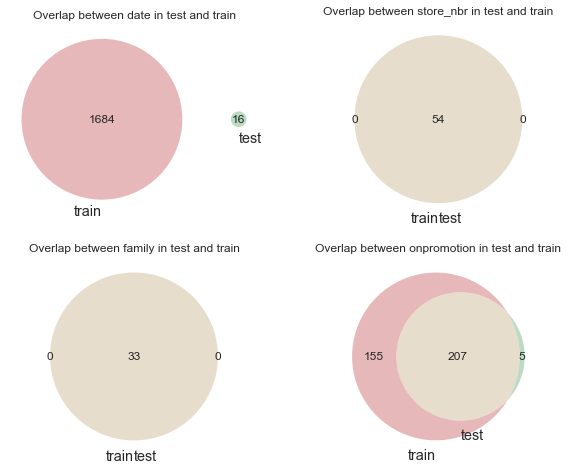

In [1139]:
#Checking Overlap of test and train 

fig, axs = plt.subplots(2, 2)
axs[0,0].set_title(f'Overlap between date in test and train')
venn2([set(df_train['date'].values), set(df_test['date'].values)], 
      set_labels = ('train','test'),ax=axs[0,0])
axs[0,1].set_title(f'Overlap between store_nbr in test and train')
venn2([set(df_train['store_nbr'].values), set(df_test['store_nbr'].values)], 
      set_labels = ('train','test'),ax=axs[0,1])
axs[1,0].set_title(f'Overlap between family in test and train')
venn2([set(df_train['family'].values), set(df_test['family'].values)], 
      set_labels = ('train','test'),ax=axs[1,0])
axs[1,1].set_title(f'Overlap between onpromotion in test and train')
venn2([set(df_train['onpromotion'].values), set(df_test['onpromotion'].values)], 
      set_labels = ('train','test'),ax=axs[1,1])

In the below plots one is a plot of sales or target variable and another is a plot of log of the sales variable.
 - In the first plot its really difficult to see the distribution because there are very huge outliers in the dataset, now since this was a kaggle competetion the metric to estimate the error of the machine learning model given is RMSLE which mean root mean squared log error, from this we can understand that the competetion orgainzers care about the outliers because these sales might happen in the future therefore when take the log of the sales we can see the outliers have been reduced i.e normalized.
 - In the second plot we can see the 'sales_log' distribution which is a normal distribution.

<AxesSubplot:xlabel='sales_log', ylabel='Count'>

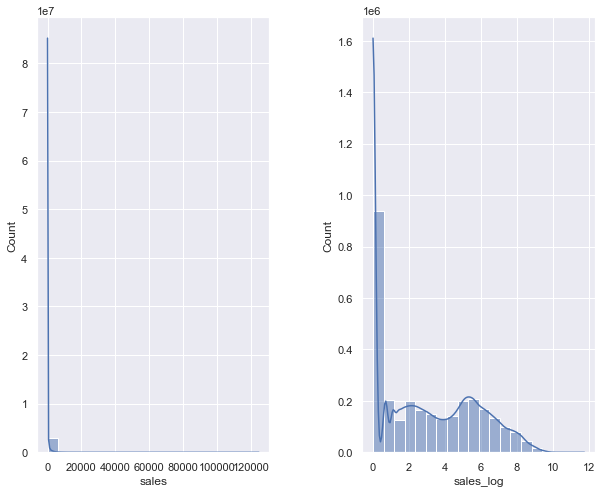

In [1140]:
df_train['sales_log'] = np.log1p(df_train['sales'])
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
sns.histplot(data=df_train,x='sales',kde=True,bins=20)
ax = fig.add_subplot(1, 2, 2)
sns.histplot(data=df_train,x='sales_log',kde=True,bins=20)


<b>A better way to see the outliers is using the box plot as shown below</b>

   - The first plot is a box plot of target variable sales.
   - The second plot is a box plot of log of target variable sales.

<AxesSubplot:ylabel='sales_log'>

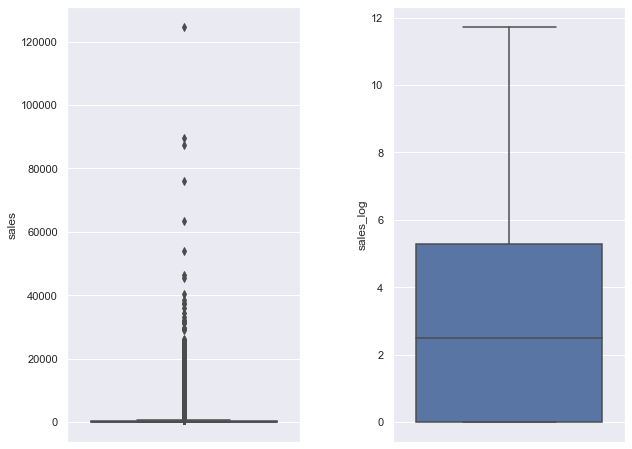

In [1141]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data=df_train,y='sales')
ax = fig.add_subplot(1, 2, 2)
sns.boxplot(data=df_train,y='sales_log')

<b>Some more count plots of the categorical variables</b>

 - From the figure below we can see that, the counts of variable 'family' and 'store_nbr' are equally distributed all along the dataset.


<AxesSubplot:xlabel='store_nbr', ylabel='count'>

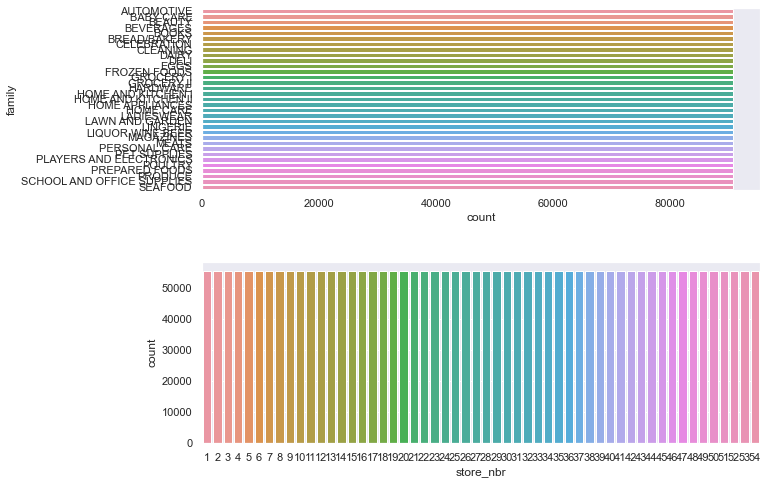

In [1142]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 1, 1)
sns.countplot(data=df_train,y = 'family')
ax = fig.add_subplot(2, 1, 2)
sns.countplot(data=df_train,x = 'store_nbr')

In [1143]:
# Some more analysis
temp = df_train.groupby('family').agg({'sales':['mean']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)

temp_nbr = df_train.groupby('store_nbr').agg({'sales':['mean']})
temp_nbr.columns = ['_'.join(x) for x in temp_nbr.columns]
temp_nbr.reset_index(inplace=True)
temp_nbr['store_nbr'] = temp_nbr['store_nbr'].astype('object')

From the plot below we can see that majority of the sales are in <b>Grocery I</b> category followed by <b>Beverages</b>, which means these are really important features for our model.

<AxesSubplot:xlabel='sales_mean', ylabel='family'>

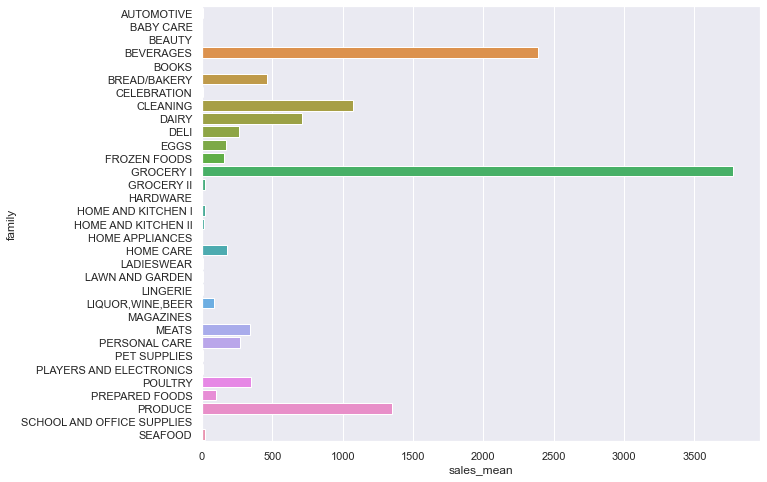

In [1144]:
sns.barplot(data=temp,x='sales_mean',y='family')


From the plot below we can see that majority of the sales are in <b>Store 44</b> followed by <b>Store 45</b>, which means these are really important features for our model too.

<AxesSubplot:xlabel='store_nbr', ylabel='sales_mean'>

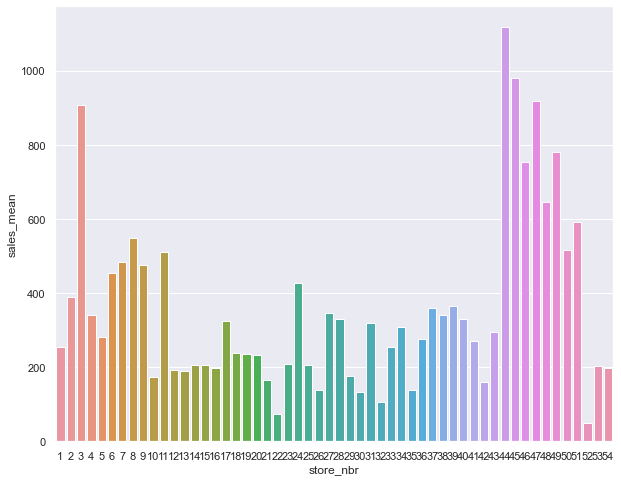

In [1145]:
sns.barplot(data=temp_nbr,x='store_nbr',y='sales_mean')

In [1146]:
# Preprocessing to merge the remaining data and also some helper functions

def preprocess_holiday(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df = df[(df['transferred']==False)&(df['type']!='Work Day')]
    event = df[df['type']=='Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi')==False]
    return df, event, earthquake


def preprocess_oil(oil):
    oil['month'] = oil['date'].map(lambda x: int(x.replace('-', '')[:6]))
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')
    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']
    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)
    oil['date'] = oil['date'].map(lambda x: date.fromisoformat(x))
    return oil

def clean_cols(x):
    if len(x.split(',')) > 1:
        return '_'.join(x.split(','))
    elif len(x.split()) > 1:
        return '_'.join(x.split())
    elif len(x.split()) > 1:
        return '_'.join(x.split('/'))
    else:
        return x

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend',color='red')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values',color='grey')
    plt.legend(loc='best')
    plt.grid(True)
    
def create_sales_lag_feats(df, gpby_cols, target_col, lags,pref='_'):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df[pref.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None,pref='_'):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df[pref.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

In [1147]:
# Preprocessing the other files and then doing analysis.
df_oil = preprocess_oil(df_oil)
holiday,event,eth = preprocess_holiday(df_holiday)

event = event[['date', 'description']]
event.rename({'description': 'event_name'}, axis=1, inplace=True)

eth = eth[['date', 'description']]
eth.rename({'description': 'earthquake'}, axis=1, inplace=True)
eth['earthquake'] = 'Terremoto Manabi'

h_local = holiday[holiday['locale']=='Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_holiday_name'}, axis=1)

h_regional = holiday[holiday['locale']=='Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_holiday_name'}, axis=1)

h_national = holiday[holiday['locale']=='National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_holiday_name'}, axis=1)

Below is some analysis on the Oil data frame
 - We can see that the distribution in the plot below

<AxesSubplot:xlabel='dcoilwtico', ylabel='Count'>

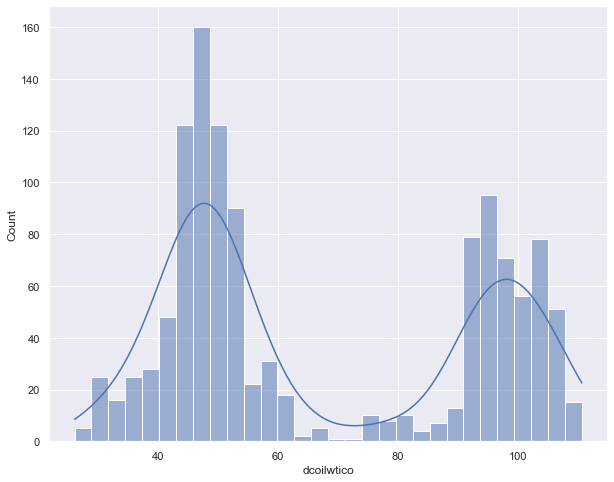

In [1148]:
sns.histplot(data=df_oil,x='dcoilwtico',kde=True,bins=30)

As you can see there seems to be a trend in the oil prices and the dates, but we still don't know how these prices actually affect the store sales, lets see that after merging the tables.

<AxesSubplot:xlabel='day_of_week', ylabel='dcoilwtico'>

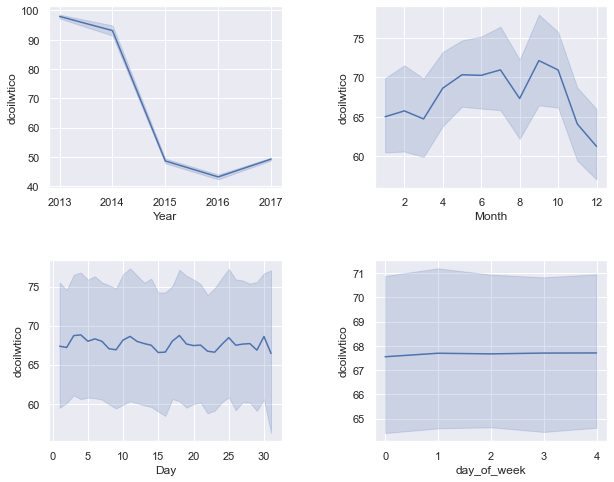

In [1149]:
temp = df_oil.copy()
temp['date'] = pd.to_datetime(temp['date'])
temp['Month'] = temp['date'].apply(lambda x: x.month)
temp['Day'] = temp['date'].apply(lambda x: x.day)
temp['day_of_week'] = temp['date'].dt.dayofweek
temp['Year'] = temp['date'].apply(lambda x: x.year)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=temp,x='Year',y='dcoilwtico')
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=temp,x='Month',y='dcoilwtico')
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=temp,x='Day',y='dcoilwtico')
ax = fig.add_subplot(2, 2, 4)
sns.lineplot(data=temp,x='day_of_week',y='dcoilwtico')

Also from the autocorrelation plot below we can see there seems to be 
some statistical significance if we lag the oil prices by 1 and 2 value, 
what i mean by that is the next day and day after the next day prices of oil 
are highly dependent on the price of the oil today.

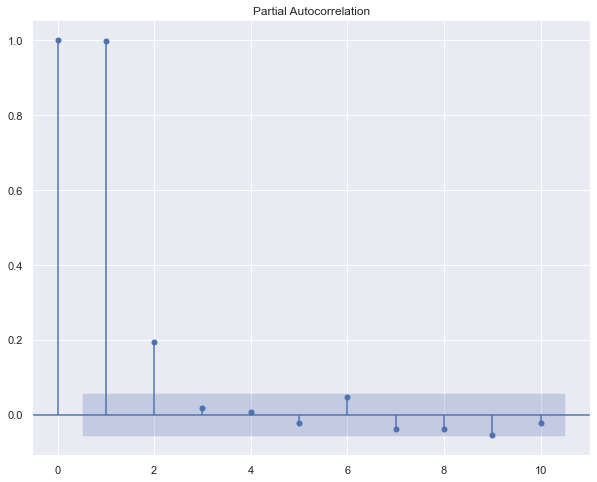

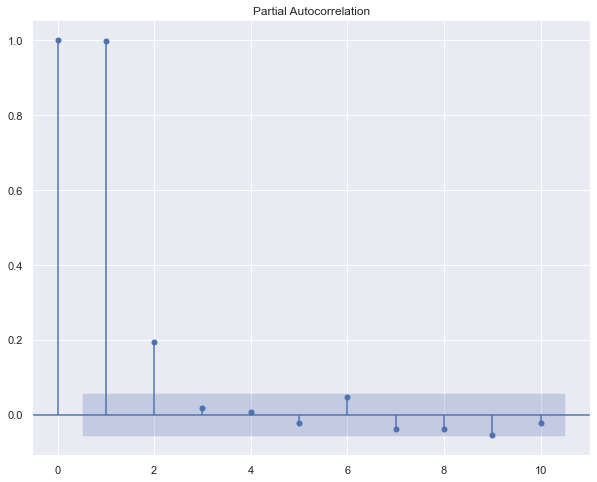

In [1150]:
plot_pacf(temp['dcoilwtico'], lags=10)

In [1151]:
"""
Merging all the additional files with the dataset and also adding the df_test data to do the proper preprocessing
such as one hot encoding or creating some statistical features.

"""

df_final = df_train.append(df_test)
df_final['date'] = df_final['date'].map(lambda x: date.fromisoformat(x))

df_final = pd.merge(df_final,df_oil,on='date',how='left')
df_final = pd.merge(df_final,event,on='date',how='left')
df_final = pd.merge(df_final,eth,on='date',how='left')
df_final = pd.merge(df_final,h_local,on='date',how='left')
df_final = pd.merge(df_final,h_national,on='date',how='left')
df_final = pd.merge(df_final,h_regional,on='date',how='left')



In [1152]:
"""

Below are some statistics of the newly formed dataset,as you can see we have a lot of null values
we are going to keep them as is for now also since we are gonna use boosted decision trees such as 
lightgbm so we dont need impute the null values we can just let the ml algorithm handle it 
internally, its recommended in the documentation of the algorithm.

"""
display(df_final.isnull().sum(),df_final.nunique())

id                             0
date                           0
store_nbr                      0
family                         0
sales                      28512
onpromotion                    0
sales_log                  28512
dcoilwtico                876744
event_name               3008016
earthquake               2995542
city                     2849418
local_holiday_name       2849418
national_holiday_name    2813778
state                    3015144
regional_holiday_name    3015144
dtype: int64

id                       3029400
date                        1700
store_nbr                     54
family                        33
sales                     379610
onpromotion                  367
sales_log                 379610
dcoilwtico                  1032
event_name                    12
earthquake                     1
city                          19
local_holiday_name            26
national_holiday_name         66
state                          4
regional_holiday_name          4
dtype: int64

In [1153]:
"""
Creating some datetime features to convert this forecasting problem in to a regression problem.

"""

df_final['date'] = pd.to_datetime(df_final['date'])
df_final['Month'] = df_final['date'].apply(lambda x: x.month)
df_final['Day'] = df_final['date'].apply(lambda x: x.day)
df_final['Year'] = df_final['date'].apply(lambda x: x.year)
df_final['day_of_week'] = df_final['date'].dt.dayofweek
df_final.sort_values(by = 'date',inplace=True)
df_final.reset_index(inplace=True,drop=True)

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

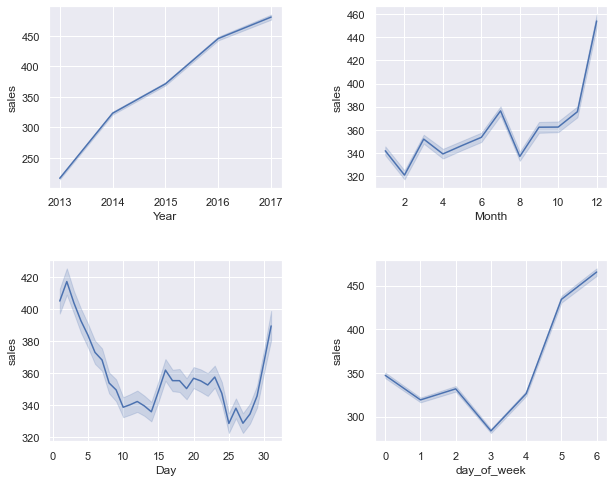

In [1154]:
"""
Below are some trends of sales with year, month day and day_of_week as a whole,

"""


temp = df_final[~df_final['sales'].isnull()]
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=temp,x='Year',y='sales')
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=temp,x='Month',y='sales')
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=temp,x='Day',y='sales')
ax = fig.add_subplot(2, 2, 4)
sns.lineplot(data=temp,x='day_of_week',y='sales')

In [1155]:
"""
Creating the date time features on the transactions data

"""

df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_transactions['Day'] = df_transactions['date'].apply(lambda x: x.day)
df_transactions['Year'] = df_transactions['date'].apply(lambda x: x.year)
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek
df_transactions['Month'] = df_transactions['date'].apply(lambda x: x.month)

<AxesSubplot:xlabel='day_of_week', ylabel='transactions'>

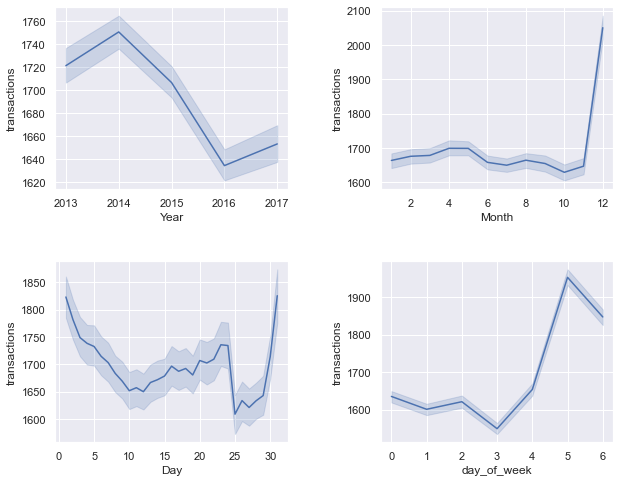

In [1156]:
"""
The transactions data is only till 2017-8-15 so we can't just merge it with train data,
therefore we are checking below if there is some relation of transaction data with year
month , day and day of week, and from the plot below we can see that there is definitley
a trend there and we need to include this feature in the model and we will do this down
below.

"""

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=df_transactions,x='Year',y='transactions')
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=df_transactions,x='Month',y='transactions')
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=df_transactions,x='Day',y='transactions')
ax = fig.add_subplot(2, 2, 4)
sns.lineplot(data=df_transactions,x='day_of_week',y='transactions')

<AxesSubplot:xlabel='day_of_week', ylabel='transactions'>

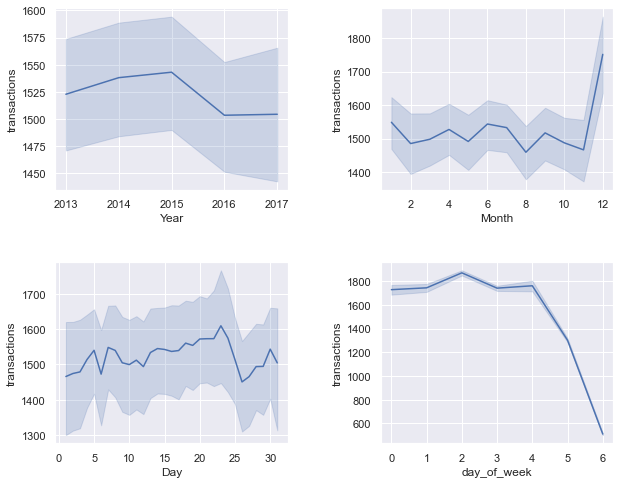

In [1157]:
"""
The plot below also tells us there maybe a different trend of transactions for every store 
too, we will check it if it exists for a family too.

"""

temp = df_transactions[df_transactions['store_nbr'] == 1]
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=temp,x='Year',y='transactions')
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=temp,x='Month',y='transactions')
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=temp,x='Day',y='transactions')
ax = fig.add_subplot(2, 2, 4)
sns.lineplot(data=temp,x='day_of_week',y='transactions')

In [1158]:
"""

Creating statistical features with transactions and then merging with df_final

"""


temp = df_transactions.groupby('store_nbr').agg({'transactions':
                                                 ['mean','median',
                                                  'sum','max','min']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)

temp_1 = df_transactions.groupby(['day_of_week','store_nbr']).agg({'transactions':
                                                                   ['mean','median','sum',
                                                                    'max','min']})
temp_1.columns = ['_dmd'.join(x) for x in temp_1.columns]
temp_1.reset_index(inplace=True)

temp_2 = df_transactions.groupby(['Month','store_nbr']).agg({'transactions':
                                                             ['mean','median',
                                                              'sum','max','min']})
temp_2.columns = ['_dm'.join(x) for x in temp_2.columns]
temp_2.reset_index(inplace=True)

temp_3 = df_transactions.groupby(['Day','store_nbr']).agg({'transactions':
                                                           ['mean','median',
                                                            'sum','max','min']})
temp_3.columns = ['_d'.join(x) for x in temp_3.columns]
temp_3.reset_index(inplace=True)

In [1159]:
"""
Merging the df_final with the transaction data statistics.

"""
df_final['family'] = df_final['family'].apply(lambda x: clean_cols(x))

df_final = pd.merge(df_final,temp,on='store_nbr',how='left')
df_final = pd.merge(df_final,temp_1,on=['day_of_week','store_nbr'],how='left')
df_final = pd.merge(df_final,temp_2,on=['Month','store_nbr'],how='left')
df_final = pd.merge(df_final,temp_3,on=['Day','store_nbr'],how='left')

df_final['date'] = pd.to_datetime(df_final['date'])
df_final.sort_values(by='date',inplace=True)
df_final.reset_index(inplace=True,drop=True)

In [1160]:

"""
Promotion in the data are comprises of just numbers , but after looking closer look at the 
statistics below it seems the stores have different promotions i.e store level promotions
and each store also has family level promotions i.e store and family level , we will
just put the count of these promotions i.e the amount of times a promotion is given 
for a store and also a store and a family
"""

temp = df_final.groupby(['store_nbr']).agg({'onpromotion':['count']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)
df_final = pd.merge(df_final,temp,on=['store_nbr'],how='left')

temp = df_final.groupby(['store_nbr','family']).agg({'onpromotion':['count']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)
df_final = pd.merge(df_final,temp,on=['store_nbr','family'],how='left')

# TIME SERIES ANALYSIS

 - Below are the some time series analysis to create some (lag features) explained above.
 - First we will check if the sales coulmn when sorted via date has some statistical significance.
 - Next we will see if there is a statistical signficance on the day level.
 - Next we will see if there is a statistical significance on the the day and store level.
 - Then we will see it on the day,store and family level
 
<b> To see these will wll use autocorrelation plots and decide what features to create and with what level </b>

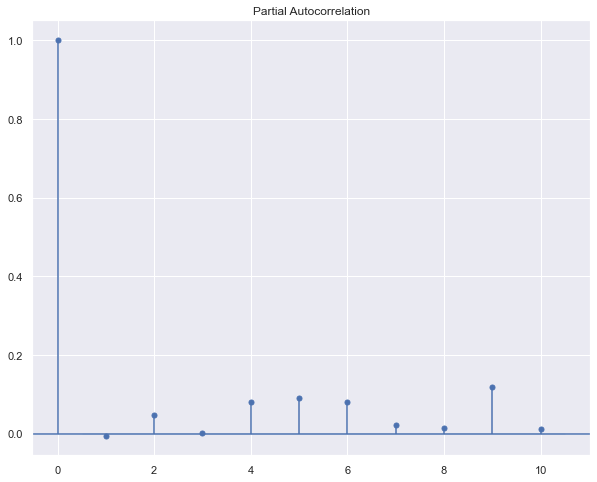

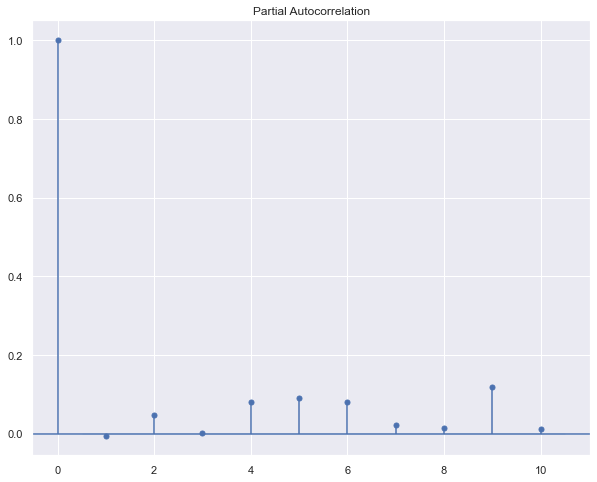

In [1161]:
"""
Autocorrelation with just the sales column, there seems to be no significance
of past value with the future value we will not use this in feature engineering.

"""
plot_pacf(df_final[~df_final['sales'].isnull()]['sales'], lags=10)

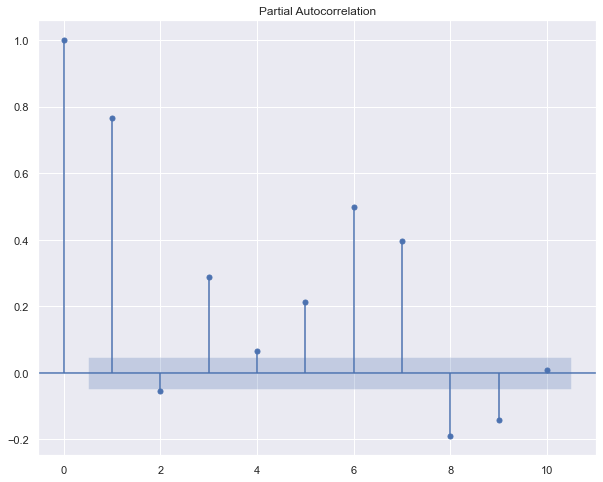

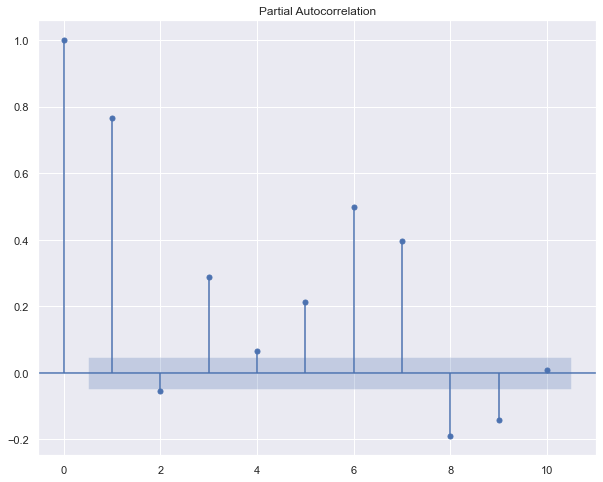

In [1162]:
"""
Autocorrelation with after groupby with date  column, there seems to a significance
of past value with the future value lets observe this more closely

"""
temp = df_final[~df_final['sales'].isnull()].groupby('date').agg({'sales':['mean']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)

plot_pacf(temp['sales_mean'], lags=10)

<b>There seems to be a really good trend when we smooth
the plot using moving averages, we could try and use this feature in our modelling.
A moving average calculates the average of a data set for a specified period. For example, the moving average of return quantities at March 2012 with a specified period of two would be calculated by adding the return quantities in February and March and then dividing that sum by two.</b>

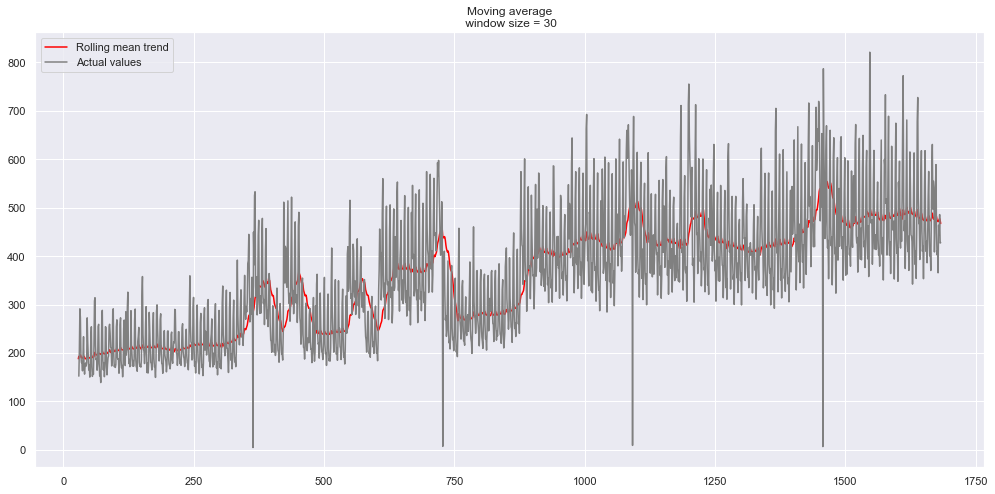

In [1163]:
plot_moving_average(temp.sales_mean, 30)

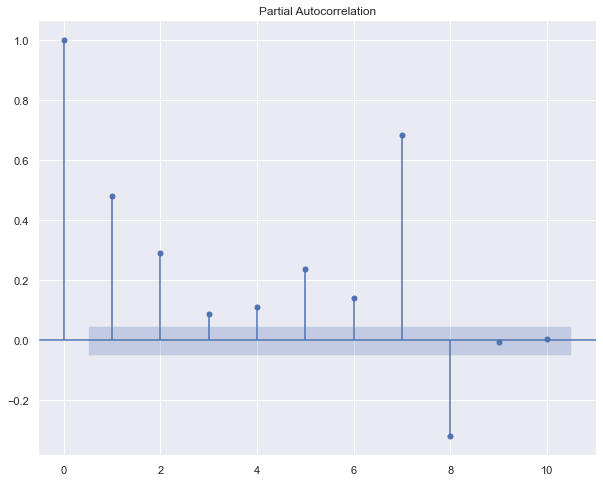

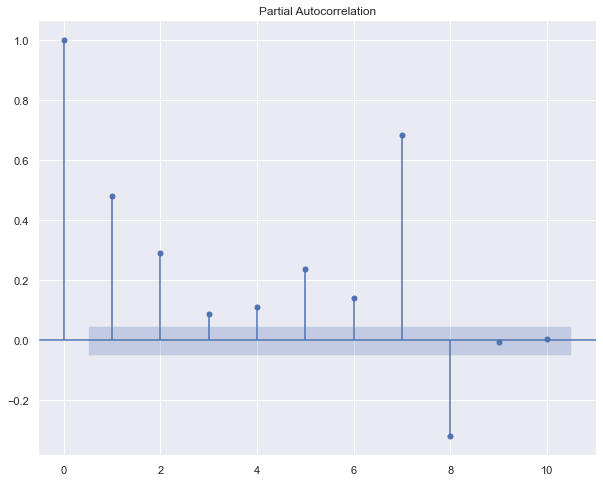

In [1164]:
"""
Autocorrelation with after groupby with date and store level column, there seems to a significance
of past value with the future value lets observe this more closely

"""


temp = df_final[~df_final['sales'].isnull()].groupby(['date','store_nbr']).agg({'sales':['mean']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)

plot_pacf(temp[temp['store_nbr'] == 1]['sales_mean'], lags=10)

<b>There seems to be a really good trend , we could try and use this feature in our modelling</b>

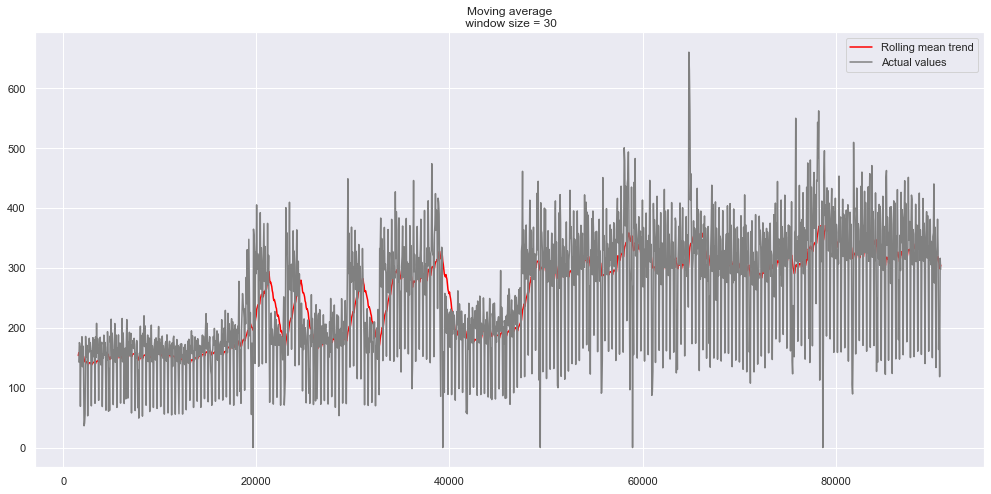

In [1165]:
plot_moving_average(temp[temp['store_nbr'] == 1]['sales_mean'], 30)

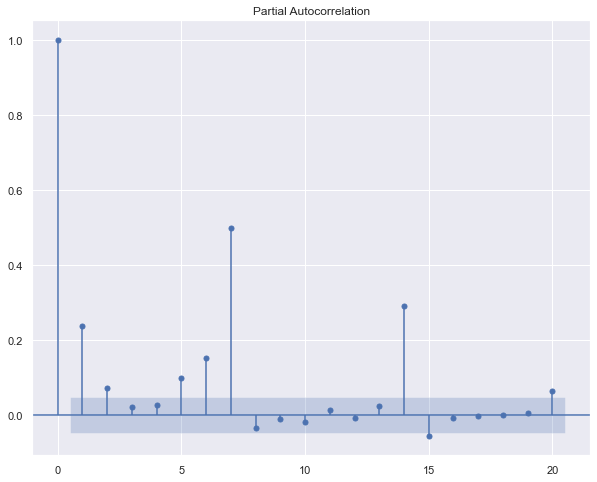

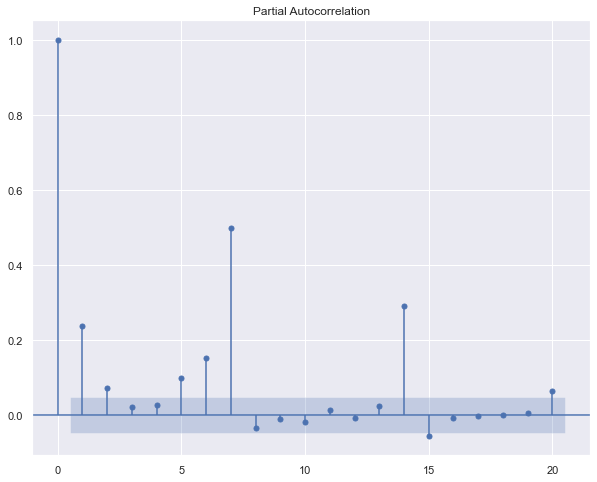

In [1166]:
"""
Autocorrelation with after groupby with date , store and family level, there seems to a significance
of past value with the future value lets observe this more closely.

"""

temp = df_final[~df_final['sales'].isnull()].groupby(['date','store_nbr','family']).agg({'sales':['mean']})
temp.columns = ['_'.join(x) for x in temp.columns]
temp.reset_index(inplace=True)

plot_pacf(temp[(temp['store_nbr'] == 1) & (temp['family'] == 'PREPARED_FOODS')]['sales_mean'], lags=20)

<b>There seems to be a really good trend , we could try and use this feature in our modelling</b>

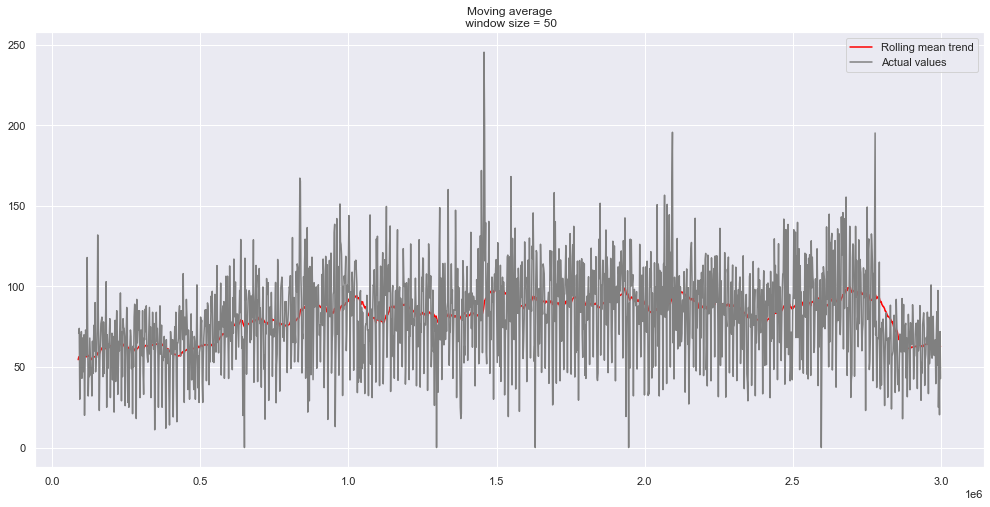

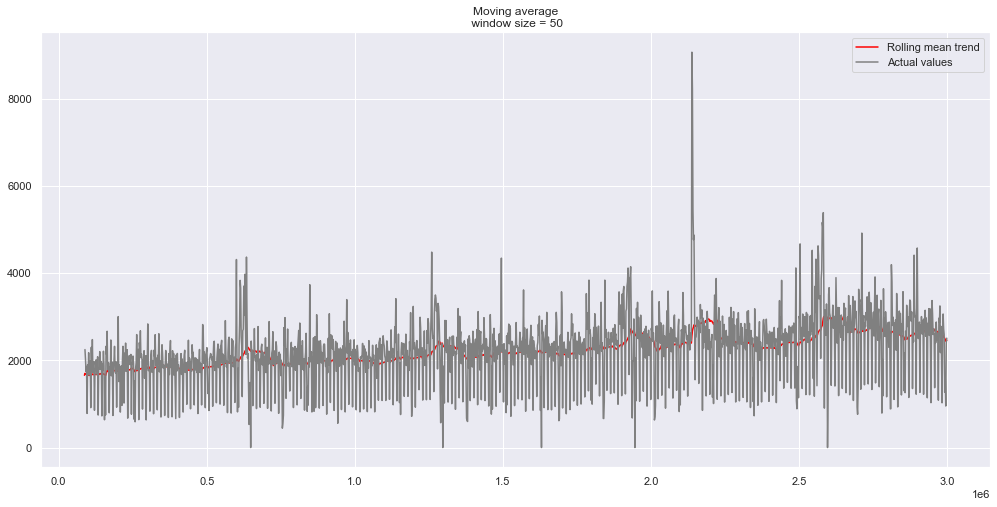

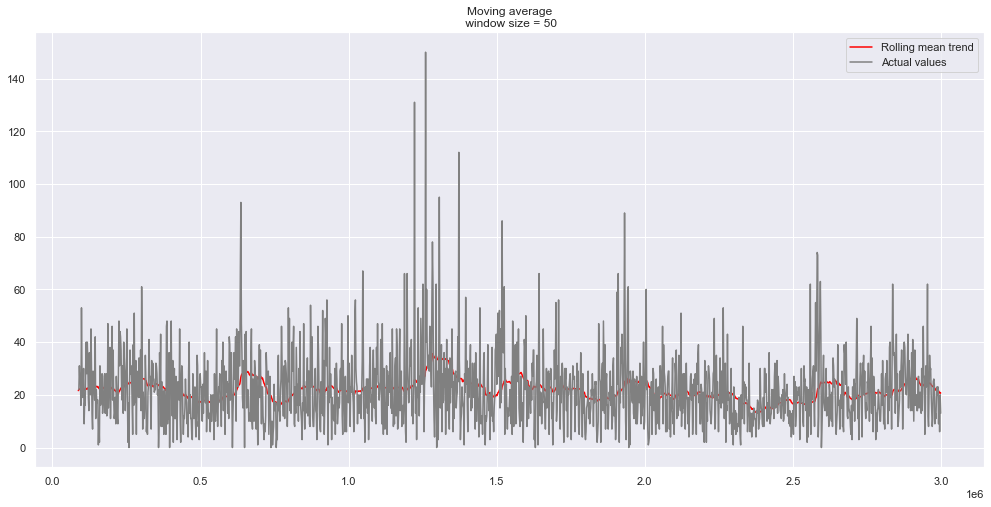

In [1167]:
plot_moving_average(temp[(temp['store_nbr'] == 1) & (temp['family'] == 'PREPARED_FOODS')]['sales_mean'], 50)
plot_moving_average(temp[(temp['store_nbr'] == 1) & (temp['family'] == 'GROCERY_I')]['sales_mean'], 50)
plot_moving_average(temp[(temp['store_nbr'] == 1) & (temp['family'] == 'GROCERY_II')]['sales_mean'], 50)

In [1168]:
df_final.head(5)

,id,date,store_nbr,family,sales,onpromotion,sales_log,dcoilwtico,event_name,earthquake,city,local_holiday_name,national_holiday_name,state,regional_holiday_name,...,transactions_dmdsum,transactions_dmdmax,transactions_dmdmin,transactions_dmmean,transactions_dmmedian,transactions_dmsum,transactions_dmmax,transactions_dmmin,transactions_dmean,transactions_dmedian,transactions_dsum,transactions_dmax,transactions_dmin,onpromotion_count_x,onpromotion_count_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,418655,2861,486,1548.668919,1761.5,229203.0,2111.0,10.0,1465.980392,1769.0,74765,1988,369,56595,1715
1,890,2013-01-01,33,SEAFOOD,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,261452,2489,640,1023.899329,1008.0,152561.0,1312.0,673.0,1170.549020,1152.0,59698,1657,913,56595,1715
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,418655,2861,486,1548.668919,1761.5,229203.0,2111.0,10.0,1465.980392,1769.0,74765,1988,369,56595,1715
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,418655,2861,486,1548.668919,1761.5,229203.0,2111.0,10.0,1465.980392,1769.0,74765,1988,369,56595,1715
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,418655,2861,486,1548.668919,1761.5,229203.0,2111.0,10.0,1465.980392,1769.0,74765,1988,369,56595,1715


/var/folders/1h/9lgp6zh90w9cxnnlvdpdxywc0000gn/T/ipykernel_1704/2990613003.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_final[~df_final['sales'].isnull()][(df_final['store_nbr'] == 1)
/var/folders/1h/9lgp6zh90w9cxnnlvdpdxywc0000gn/T/ipykernel_1704/2990613003.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_final[~df_final['sales'].isnull()][(df_final['store_nbr'] == 1)


<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

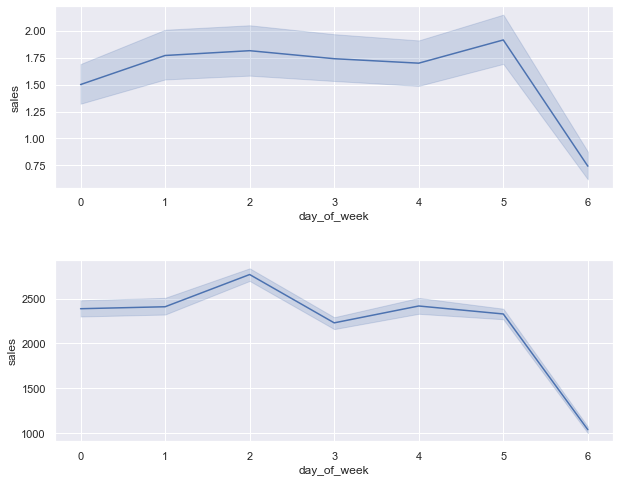

In [1169]:
"""
Some trends on the store and family level , we can use this
for the modelling the features really could help with the 
rmsle score with our model.

"""
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 1, 1)
sns.lineplot(data=df_final[~df_final['sales'].isnull()][(df_final['store_nbr'] == 1) 
                                                        & (df_final['family'] == 'HARDWARE')],
             x='day_of_week',y='sales',estimator=np.mean)
ax = fig.add_subplot(2, 1, 2)
sns.lineplot(data=df_final[~df_final['sales'].isnull()][(df_final['store_nbr'] == 1) 
                                                        & (df_final['family'] == 'GROCERY_I')],
             x='day_of_week',y='sales',estimator=np.mean)



<b> Now we will create some lag features</b>
 - We will create some lag features with oil prices, as seen from the graph below there seems to be a relation between oil price that day and the prices of the store items.

<AxesSubplot:xlabel='dcoilwtico', ylabel='sales'>

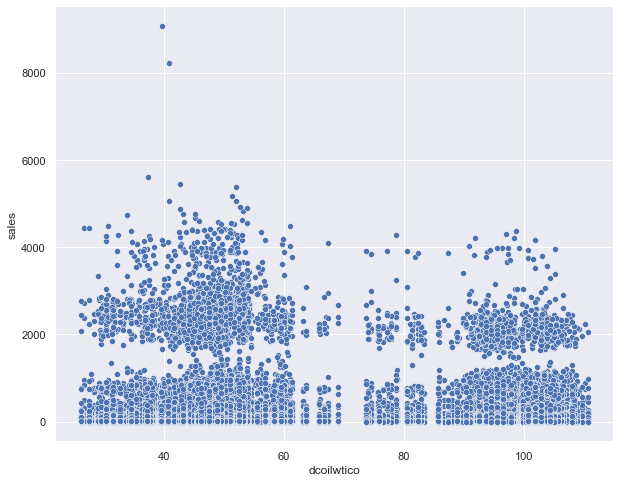

In [1170]:
temp = df_final[~df_final['sales'].isnull()]
sns.scatterplot(data=temp,y = temp[temp['store_nbr'] == 1]['sales'],
                x = temp[temp['store_nbr'] == 1]['dcoilwtico'])

Amount of sales seem to reduce when the oil prices are high

In [1171]:
# Oil prices lag features

df_final['dcoilwtico_lag1'] = df_final['dcoilwtico'].shift(1)
df_final['dcoilwtico_lag2'] = df_final['dcoilwtico'].shift(2)

In [1172]:
#Lag features on day,store and family level

create_sales_lag_feats(df_final,gpby_cols=['Day','store_nbr','family'],
                       target_col='sales',lags=[1,2,5,6,7,13,20])

#Rolling mean features on day,store and family level
create_sales_rmean_feats(df_final,gpby_cols=['Day','store_nbr','family'],
                         target_col='sales',windows=[2,5,6,7,13,20])

,id,date,store_nbr,family,sales,onpromotion,sales_log,dcoilwtico,event_name,earthquake,city,local_holiday_name,national_holiday_name,state,regional_holiday_name,...,dcoilwtico_lag1,dcoilwtico_lag2,sales_lag_1,sales_lag_2,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_13,sales_lag_20,sales_rmean_2,sales_rmean_5,sales_rmean_6,sales_rmean_7,sales_rmean_13,sales_rmean_20
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,890,2013-01-01,33,SEAFOOD,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,94.756667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,94.756667,94.756667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,94.756667,94.756667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,94.756667,NaN,NaN,NaN,NaN,Primer dia del ano,NaN,NaN,...,94.756667,94.756667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056125,3029394,2017-08-31,9,PLAYERS_AND_ELECTRONICS,NaN,0,NaN,47.260000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.260000,47.260000,3.667918,15.343735,0.036957,4.161703,5.925526,27.467083,8.642736,11.504831,170.087650,146.324275,126.632184,122.715413,560.546647
3056126,3029395,2017-08-31,9,POULTRY,NaN,1,NaN,47.260000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.260000,47.260000,473.000798,376.378873,687.768267,386.443944,358.183685,596.914800,376.245858,237.124907,263.248750,217.483967,192.124629,155.181507,540.923808
3056127,3029396,2017-08-31,9,PREPARED_FOODS,NaN,0,NaN,47.260000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.260000,47.260000,62.363871,166.696000,99.583287,86.615471,101.358114,132.434980,46.617191,265.565768,204.580312,225.166262,196.816335,158.894680,515.705184
3056128,3029386,2017-08-31,9,LADIESWEAR,NaN,0,NaN,47.260000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.260000,47.260000,7.336959,10.419776,11.758646,10.074110,6.910212,13.204736,8.506462,33.917038,113.408073,170.124418,197.348519,159.368731,497.669977


In [1173]:
# Encoding all the categorical variables with label encoder for the model.

lb = LabelEncoder()
df_final['city'] = lb.fit_transform(df_final['city'])
df_final['local_holiday_name'] = lb.fit_transform(df_final['local_holiday_name'])
df_final['national_holiday_name'] = lb.fit_transform(df_final['national_holiday_name'])
df_final['regional_holiday_name'] = lb.fit_transform(df_final['regional_holiday_name'])
df_final['state'] = lb.fit_transform(df_final['state'])
df_final['earthquake'] = lb.fit_transform(df_final['earthquake'])
df_final['event_name'] = lb.fit_transform(df_final['event_name'])
df_final['onpromotion'] = lb.fit_transform(df_final['onpromotion'])
df_final['family_cpy'] =  df_final['family']

#Using the one hot encoding on the family column

df_final = pd.get_dummies(data=df_final,columns=['family'])

In [1174]:
#Creating a test set and a train set

df_test = df_final[df_final['sales'].isnull()]
df_test.reset_index(inplace=True,drop=True)

df_train= df_final[~df_final['sales'].isnull()]
df_train.reset_index(inplace=True,drop=True)

In [1175]:
df_test.drop(['sales','family_cpy','sales_log'],axis=1,inplace=True)
df_test.sort_values(by='date',inplace=True)

/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/1h/9lgp6zh90w9cxnnlvdpdxywc0000gn/T/ipykernel_1704/3529128122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.sort_values(by='date',inplace=True)


# MODELLING

 - Below we are creating a train set and a holdout set , this holdout set is created to evalute the performance of the model and also used in early stopping to reduce overfitting.
 - Holdout set helps to evaluate model performance on the test set too it tells us how the model is going to perform on the unseen data.
 - Since the aim of this project is to forecast the sales in the future we are gonna use the systematic sampling to divide the data by dates. 
 - The holdout data is from 2017-08-01 to 2017-08-15, train data is 2013 to 2017-07-30 and the test data is 2017-08-16 to 2017-08-30.

In [1176]:
X_valid = df_train[df_train['date'] >= '2017-08-01 00:00:00']
X_train = df_train[(df_train['date'] < '2017-08-01 00:00:00')]

y_train = np.log1p(X_train['sales'])
y_valid = X_valid['sales']

X_train.drop(['sales','id','date','family_cpy','sales_log'],axis=1,inplace=True)
X_valid.drop(['sales','id','date','family_cpy','sales_log'],axis=1,inplace=True)

<b>The modelling is done using lightgbm and RMSLE as a cost function</b>.
 - Why RMSLE? The use of RMSLE as a cost function is because it the log of target normalizes the outliers i.e it reduce the standard deviation of the target variable so that the machine learning model can perform well.
 - Basically it turns the target value 'sales' in our case to a gaussian distribution.
 - The RMSLE is used in cases where we need the outliers because we are expecting those outliers to occur in the future data too.
 - Model we have used here is a boosting decision tree one, i.e Lightgbm made by microsoft.
 - One of the reasons to use LGBM was because of how fast it is and the low memory usage.
 - Lgbm can handle the nan values directly and according to the documentation its better to keep the values as nan and not impute it, but it varies on dataset to dataset.

In [1180]:
clf  = lgb.LGBMRegressor(random_state=22,n_jobs=-1,n_estimators=1500)
clf.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_valid,np.log1p(y_valid))], 
        verbose=False,early_stopping_rounds=100)
score = np.sqrt(mean_squared_error(y_pred=clf.predict(X_valid),y_true=np.log1p(y_valid)))
print(f'The Holdout RMSLE Is : {score}')
test_preds = np.expm1(clf.predict(df_test.drop(['id','date'],axis=1)))

The Holdout RMSLE Is : 0.439458864087296


## Feature Importance

The feature importance is a really good tool to identify if the features we created i.e our hypothesis from analysis of the dataset is true or not.
 - The Top feature is the sales_lag_1 feature that we hypothesized that was an important one.
 - The sales_lag_1 feature is created on the date,store and family level and the autocorrelation plot suggested that a lag of 1 had a statistical significance.
 - We also saw the moving average plot of this and it showed a significant trend by day and from the importance we can see that this feature is very important to out model.
 - For feature importance we used rfpimp which is a permuatation feature importance technique.
 - Why did we use this, instead of lgbm inbuilt feature importance? The inbuilt feature importance of lightgbm is highly random and permutation importance reduces that randomization.

In [1181]:
imp = importances(clf,X_valid,y_valid)
imp

,Importance
Feature,
sales_lag_1,6.890951e-04
sales_lag_2,4.022221e-04
onpromotion,2.159049e-04
transactions_dmsum,2.001043e-04
sales_lag_6,8.722933e-05
sales_lag_5,6.451224e-05
transactions_dmdsum,6.070097e-05
sales_lag_7,3.579793e-05
sales_lag_13,3.359861e-05


In [1182]:
"""
Prediction on the test data

"""

df_test['preds'] = test_preds
df_sub = pd.read_csv("sample_submission.csv")
df_sub.drop('sales',axis=1,inplace=True)
df_sub = pd.merge(df_sub,df_test[['id','preds']],on='id')
df_sub.rename(columns={
    'preds':'sales'
},inplace=True)
df_sub['sales']= df_sub['sales'].apply(lambda x: 0 if x < 0 else x)
df_sub.to_csv('preds_1.csv',index=False)

/var/folders/1h/9lgp6zh90w9cxnnlvdpdxywc0000gn/T/ipykernel_1704/1230583083.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = test_preds


In [1183]:
#Prediction stats

display(df_sub.describe())

,id,sales
count,2.851200e+04,28512.000000
mean,3.015144e+06,435.850098
std,8.230850e+03,1184.777024
min,3.000888e+06,0.000000
25%,3.008016e+06,3.709333
50%,3.015144e+06,26.634612
75%,3.022271e+06,251.477795
max,3.029399e+06,14010.055094


# CONCLUSION

 - This was a amazing dataset to work with, forecasting is not easy and seeing the trends was really exiciting.
 - I learned a lot about lag features, what is rolling mean etc.
 - I also learned that in time series problem there could be different trends in a dataset, and we need to include all those in the model for the best accuracy.
 - For example in this dataset there were trends based on a day,month , day of the week and year. But there also trends in the sublevel such as each store had a different trent on a day and even for a certain product.
 - We can create multiple models via each store to get a really good accuracy but in the real world that would cause a huge overload imagine creating 100 models for hundered stores.
 - We can also use a way simpler model such as linear regression or even a forecasting model such as anova or prophet they work really well for forecasting problems but i tried to use decision trees which theoretically find it difficult to extrapolate to future values.
 - I learned a lot about feature engineering and also overfitting.
 - I also had a really good leaderboard score for this dataset on kaggle, and my model seem to not overfit as much.
     - Holdout Score (RMSLE Less is better) :- 0.439458864087296
     - Test Score :- 0.48951
     - Leaderboard Rank :- 158/882